<a href="https://colab.research.google.com/github/Lorddickenstein/FSLRwithNLP/blob/main/Application/CNN_Model_Experiment1_Letters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
from google.colab import files

from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Flatten, MaxPool2D, Conv2D, Dropout, BatchNormalization
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import glob
import warnings
import random
import shutil
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

# Data Preparation

In [24]:
root = '/content/drive/MyDrive/Colab Notebooks/Datasets/OurDataset/Experiments/Experiment_1'

letters = ['A', 'B', 'C', 'D', 'E',
           'F', 'G', 'H', 'I', 'J',
           'K', 'L', 'M', 'N', 'O',
           'P', 'Q', 'R', 'S', 'T',
           'U', 'V', 'W', 'X', 'Y',
           'Z']

train_size = 50
valid_size = 20
test_size = 10


In [25]:
def make_dir(path, class_obj):
  for obj in class_obj:
    path_class = os.path.join(path, obj)
    os.makedirs(path_class)

In [26]:
# Create Train, Valid, Test directories
train_path = os.path.join(root, 'Train')
valid_path = os.path.join(root, 'Valid')
test_path = os.path.join(root, 'Test')

if os.path.isdir(train_path) is False:
  make_dir(train_path, letters)
  make_dir(valid_path, letters)
  make_dir(test_path, letters)
else:
  print("Directory already exisits.")


# Populate Train, Valid and Test Folders

In [27]:
# Make a folder for every classes
dataset_experiment = '/content/drive/MyDrive/Colab Notebooks/Datasets/OurDataset/Experiments/Dataset_Experiments'
make_dir(dataset_experiment, letters)

In [28]:
# Copy Dataset to Experiment Dataset
dataset_root = '/content/drive/MyDrive/Colab Notebooks/Datasets/OurDataset/Raw_Dataset'
dataset_path = os.path.join(dataset_root, 'Letters')
for letter in letters:
  path_class = os.path.join(dataset_path, letter)
  path_class_dest = os.path.join(dataset_experiment, letter)
  for item in os.listdir(path_class):
    shutil.copy(os.path.join(path_class, item), path_class_dest)

In [29]:
# temporary size
train_size = 30
valid_size = 15
test_size = 5

# Train
for letter in letters:
  path_class = os.path.join(dataset_experiment, letter)
  os.chdir(path_class)
  if len(os.listdir(path_class)) != 0:
    for item in random.sample(glob.glob(letter + '_*'), train_size):
      shutil.move(item, os.path.join(train_path, letter))

# Valid
for letter in letters:
  path_class = os.path.join(dataset_experiment, letter)
  os.chdir(path_class)
  if len(os.listdir(path_class)) != 0:
    for item in random.sample(glob.glob(letter + '_*'), valid_size):
      shutil.move(item, os.path.join(valid_path, letter))

# Test
for letter in letters:
  path_class = os.path.join(dataset_experiment, letter)
  os.chdir(path_class)
  if len(os.listdir(path_class)) != 0:
    for item in random.sample(glob.glob(letter + '_*'), test_size):
      shutil.move(item, os.path.join(test_path, letter))

# Preprocess Image

In [30]:
image_size = (224, 224)

In [39]:
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=image_size, classes=letters, batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=image_size, classes=letters, batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=image_size, classes=letters, batch_size=10)

Found 720 images belonging to 26 classes.
Found 360 images belonging to 26 classes.
Found 120 images belonging to 26 classes.


In [43]:
# Subtract empty class
assert train_batches.n == (30*26) - 60
assert valid_batches.n == (15*26) - 30
assert test_batches.n == (5*26) - 10

In [44]:
imgs, labels = next(train_batches)

In [48]:
# Plot 10 sample images
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20, 20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

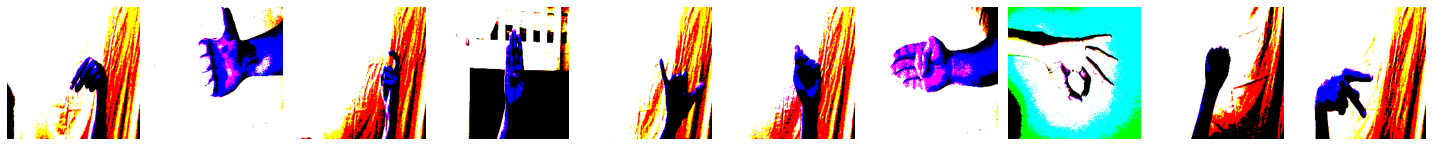

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]


In [49]:
plotImages(imgs)
print(labels)

# Build and Train Model

In [50]:
# Count the total classes that the model must know
total_classes = len(os.listdir(train_path))
print(total_classes)

26


In [52]:
# Create the Sequential Model
model = Sequential()

# Add Layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(total_classes, activation='softmax'))

# Summary of layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [53]:
# Create the connection and train the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
model.fit(x=train_batches, validation_data=valid_batches, batch_size=15, epochs=20)

# Evaluate the model with test_sets
print(model.evaluate(test_batches))

Epoch 1/20
72/72 [==============================] - 136s 2s/step - loss: 48.2272 - accuracy: 0.0583 - val_loss: 3.2389 - val_accuracy: 0.0972
Epoch 2/20
72/72 [==============================] - 126s 2s/step - loss: 3.1898 - accuracy: 0.1042 - val_loss: 3.1255 - val_accuracy: 0.1278
Epoch 3/20
72/72 [==============================] - 126s 2s/step - loss: 2.7888 - accuracy: 0.2097 - val_loss: 2.8053 - val_accuracy: 0.2139
Epoch 4/20
72/72 [==============================] - 127s 2s/step - loss: 1.9863 - accuracy: 0.4389 - val_loss: 2.5808 - val_accuracy: 0.2722
Epoch 5/20
72/72 [==============================] - 129s 2s/step - loss: 1.1067 - accuracy: 0.6694 - val_loss: 2.6155 - val_accuracy: 0.3083
Epoch 6/20
72/72 [==============================] - 125s 2s/step - loss: 0.7048 - accuracy: 0.7958 - val_loss: 2.8205 - val_accuracy: 0.3611
Epoch 7/20
72/72 [==============================] - 125s 2s/step - loss: 0.4414 - accuracy: 0.8542 - val_loss: 2.7666 - val_accuracy: 0.3417
Epoch 8/20
7

# Save the Model

In [54]:
# save the model
model_name = 'Fingerspell_Detector_Experiment1.h5'
path = '/content/drive/MyDrive/Colab Notebooks/CNN Models/' + model_name
model.save(path)